In [1]:
import pandas as pd
import numpy as np 
import tensorflow as tf 
from tensorflow.keras import models, layers
import matplotlib.pyplot as plt
import os
import hashlib
from PIL import Image


### Menyiapkan dataset

In [2]:
image_size = (256, 256)
batch_size = 32
dataset = tf.keras.preprocessing.image_dataset_from_directory(
    'D:/Kegiatan lain/Stechoq/dataset tugas akhir/dataset',
    shuffle=True,
    image_size = image_size, 
    batch_size = batch_size
)

Found 4217 files belonging to 4 classes.


### Visualisasi sample dataset

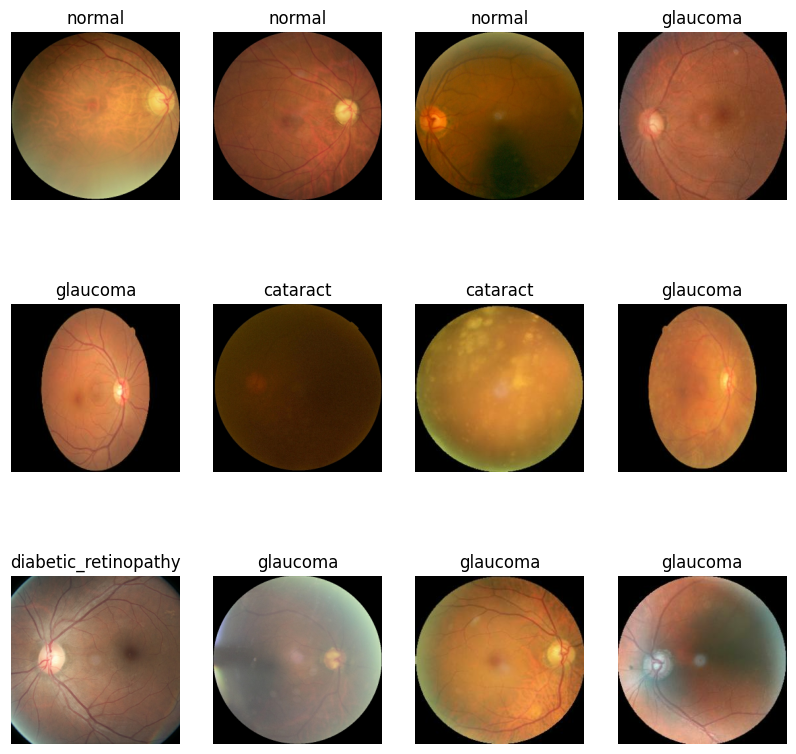

In [3]:
class_names = dataset.class_names
plt.figure(figsize=(10, 10))
for image_batch, label_batch in dataset.take(1): 
    for i in range(12): 
        ax = plt.subplot(3, 4, i + 1)
        plt.imshow(image_batch[i].numpy().astype('uint8'))
        plt.title(class_names[label_batch[i]])
        plt.axis('off')

### Preprocessing dataset

In [4]:
#Memeriksa apakah ada data yang duplikat
def generate_image_hash(image_path):
    """Menghasilkan hash untuk gambar"""
    try:
        with Image.open(image_path) as img:
            # Konversi gambar ke ukuran yang sama untuk membuat perbandingan lebih mudah
            img = img.resize((256, 256))
            img_hash = hashlib.md5(img.tobytes()).hexdigest()
        return img_hash
    except Exception as e:
        print(f"Error processing image {image_path}: {e}")
        return None

def find_duplicate_images(folder_path):
    """Mencari gambar duplikat dalam folder"""
    hashes = {}
    duplicates = []

    # Iterasi melalui semua file dalam folder
    for filename in os.listdir(folder_path):
        file_path = os.path.join(folder_path, filename)

        # Cek apakah file adalah gambar
        if filename.lower().endswith(('.png', '.jpg', '.jpeg', '.bmp', '.gif')):
            img_hash = generate_image_hash(file_path)

            # Lanjutkan jika hash berhasil dihasilkan
            if img_hash:
                # Cek apakah hash sudah ada di kamus
                if img_hash in hashes:
                    duplicates.append((file_path, hashes[img_hash]))
                else:
                    hashes[img_hash] = file_path

    return duplicates

# Penggunaan
folder_path = 'D:/Kegiatan lain/Stechoq/dataset tugas akhir/dataset'  # Ganti dengan path folder Anda
dups = find_duplicate_images(folder_path)

if dups:
    print("Gambar duplikat ditemukan:")
    for dup in dups:
        print(f"Duplikat: {dup[0]} adalah salinan dari {dup[1]}")
else:
    print("Tidak ada gambar duplikat ditemukan.")


Tidak ada gambar duplikat ditemukan.


In [5]:
#Melakukan rescaling dan resize
resize_and_rescale = tf.keras.Sequential([
    layers.Resizing(256, 256), 
    layers.Rescaling(1.0 / 255)
])

### Membagi dataset

In [6]:
def get_dataset(ds, train_split=0.8, val_split=0.1, test_split=0.1, shuffle=True, shuffle_size=10000):
    ds_size = len(ds)
    if shuffle: 
        ds = ds.shuffle(shuffle_size, seed=8)
    train_size = int(train_split * ds_size)
    val_size = int(val_split * ds_size)
    train_ds = ds.take(train_size)
    val_ds = ds.skip(train_size).take(val_size)
    test_ds = ds.skip(train_size).skip(val_size)
    return train_ds, val_ds, test_ds

train_ds, val_ds, test_ds = get_dataset(dataset)

### Model CNN

In [7]:
n_classes = 4
input_shape = (batch_size, 256, 256, 3)
model = models.Sequential([
    resize_and_rescale,
    layers.Conv2D(32, (3, 3), activation='relu', input_shape=input_shape),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64, kernel_size=(3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)), 
    layers.Flatten(), 
    layers.Dense(64, activation='relu'),
    layers.Dense(n_classes, activation='softmax'),
])
model.build(input_shape=input_shape)
model.summary()

d:\Kampus\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ sequential (Sequential)         │ (32, 256, 256, 3)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (32, 254, 254, 32)     │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (32, 127, 127, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (32, 125, 125, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (32, 62, 62, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (32, 246016)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (32, 64)               │    15,745,088 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (32, 4)                │           260 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 15,764,740 (60.14 MB)

 Trainable params: 15,764,740 (60.14 MB)

 Non-trainable params: 0 (0.00 B)

### Kompilasi model

In [8]:
model.compile(
    optimizer='adam',
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
    metrics=['accuracy']
)

### Melatih model

In [10]:
history = model.fit(
    train_ds,
    epochs=20,
    batch_size=batch_size,
    verbose=1,
    validation_data=val_ds
)

Epoch 1/20
105/105 ━━━━━━━━━━━━━━━━━━━━ 325s 3s/step - accuracy: 0.7943 - loss: 0.4945 - val_accuracy: 0.8341 - val_loss: 0.4716
Epoch 2/20
105/105 ━━━━━━━━━━━━━━━━━━━━ 315s 3s/step - accuracy: 0.8211 - loss: 0.4577 - val_accuracy: 0.8197 - val_loss: 0.4140
Epoch 3/20
105/105 ━━━━━━━━━━━━━━━━━━━━ 312s 3s/step - accuracy: 0.8272 - loss: 0.4172 - val_accuracy: 0.8293 - val_loss: 0.4372
Epoch 4/20
105/105 ━━━━━━━━━━━━━━━━━━━━ 315s 3s/step - accuracy: 0.8268 - loss: 0.4202 - val_accuracy: 0.8678 - val_loss: 0.3563
Epoch 5/20
105/105 ━━━━━━━━━━━━━━━━━━━━ 182s 1s/step - accuracy: 0.8546 - loss: 0.3877 - val_accuracy: 0.8678 - val_loss: 0.3232
Epoch 6/20
105/105 ━━━━━━━━━━━━━━━━━━━━ 238s 2s/step - accuracy: 0.8634 - loss: 0.3648 - val_accuracy: 0.8702 - val_loss: 0.3481
Epoch 7/20
105/105 ━━━━━━━━━━━━━━━━━━━━ 257s 2s/step - accuracy: 0.8573 - loss: 0.3641 - val_accuracy: 0.8798 - val_loss: 0.3591
Epoch 8/20
105/105 ━━━━━━━━━━━━━━━━━━━━ 266s 2s/step - accuracy: 0.8663 - loss: 0.3523 - val_accu

In [11]:
history = model.fit(
    train_ds, 
    epochs=25,
    initial_epoch=20, 
    batch_size=batch_size,
    verbose=1,
    validation_data=val_ds
)

Epoch 21/25
105/105 ━━━━━━━━━━━━━━━━━━━━ 219s 2s/step - accuracy: 0.9379 - loss: 0.1571 - val_accuracy: 0.9519 - val_loss: 0.1524
Epoch 22/25
105/105 ━━━━━━━━━━━━━━━━━━━━ 224s 2s/step - accuracy: 0.9352 - loss: 0.1768 - val_accuracy: 0.9351 - val_loss: 0.1619
Epoch 23/25
105/105 ━━━━━━━━━━━━━━━━━━━━ 209s 2s/step - accuracy: 0.9496 - loss: 0.1363 - val_accuracy: 0.9535 - val_loss: 0.1229
Epoch 24/25
105/105 ━━━━━━━━━━━━━━━━━━━━ 237s 2s/step - accuracy: 0.9577 - loss: 0.1182 - val_accuracy: 0.9255 - val_loss: 0.1785
Epoch 25/25
105/105 ━━━━━━━━━━━━━━━━━━━━ 263s 2s/step - accuracy: 0.9557 - loss: 0.1292 - val_accuracy: 0.9495 - val_loss: 0.1232


### Evaluasi

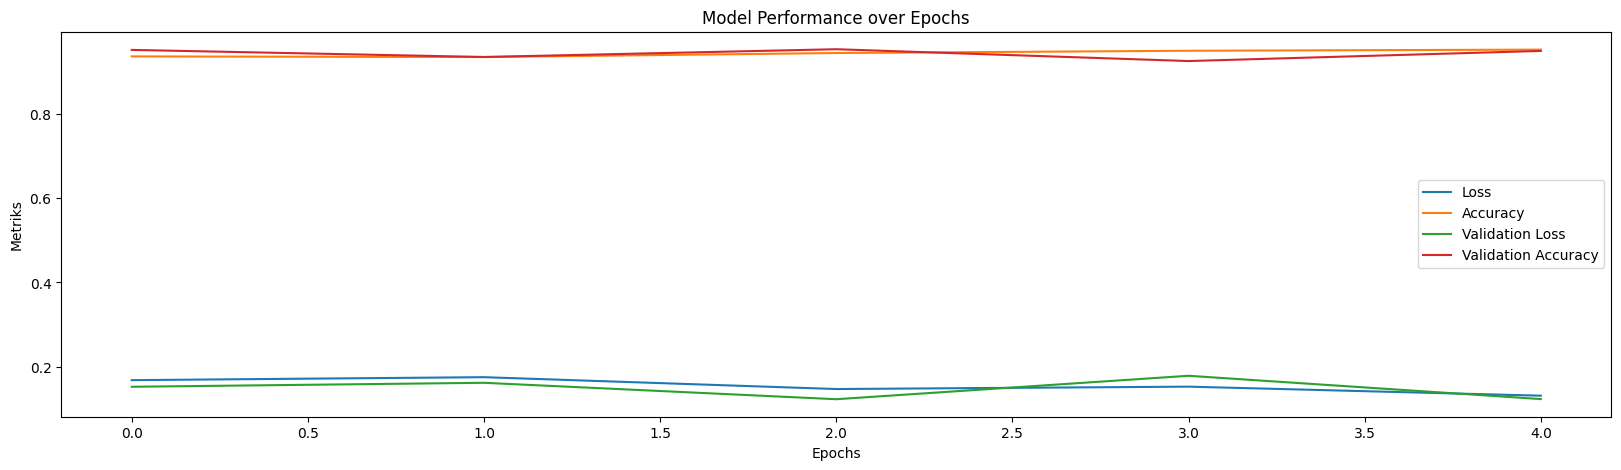

In [12]:
his_data = pd.DataFrame(history.history)

plt.figure(figsize=(20, 5))

plt.plot(his_data['loss'], label='Loss')
plt.plot(his_data['accuracy'], label='Accuracy')
plt.plot(his_data['val_loss'], label='Validation Loss')
plt.plot(his_data['val_accuracy'], label='Validation Accuracy')

plt.legend()
plt.xlabel('Epochs')
plt.ylabel('Metriks')
plt.title('Model Performance over Epochs')

plt.show()

### Tes Model 

First Image to Predict :

Actual label: normal
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step

Predicted label normal
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 987ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 100ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step


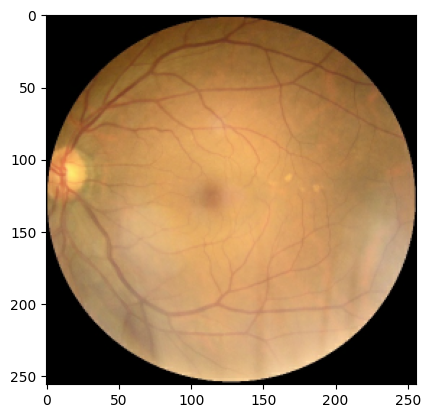

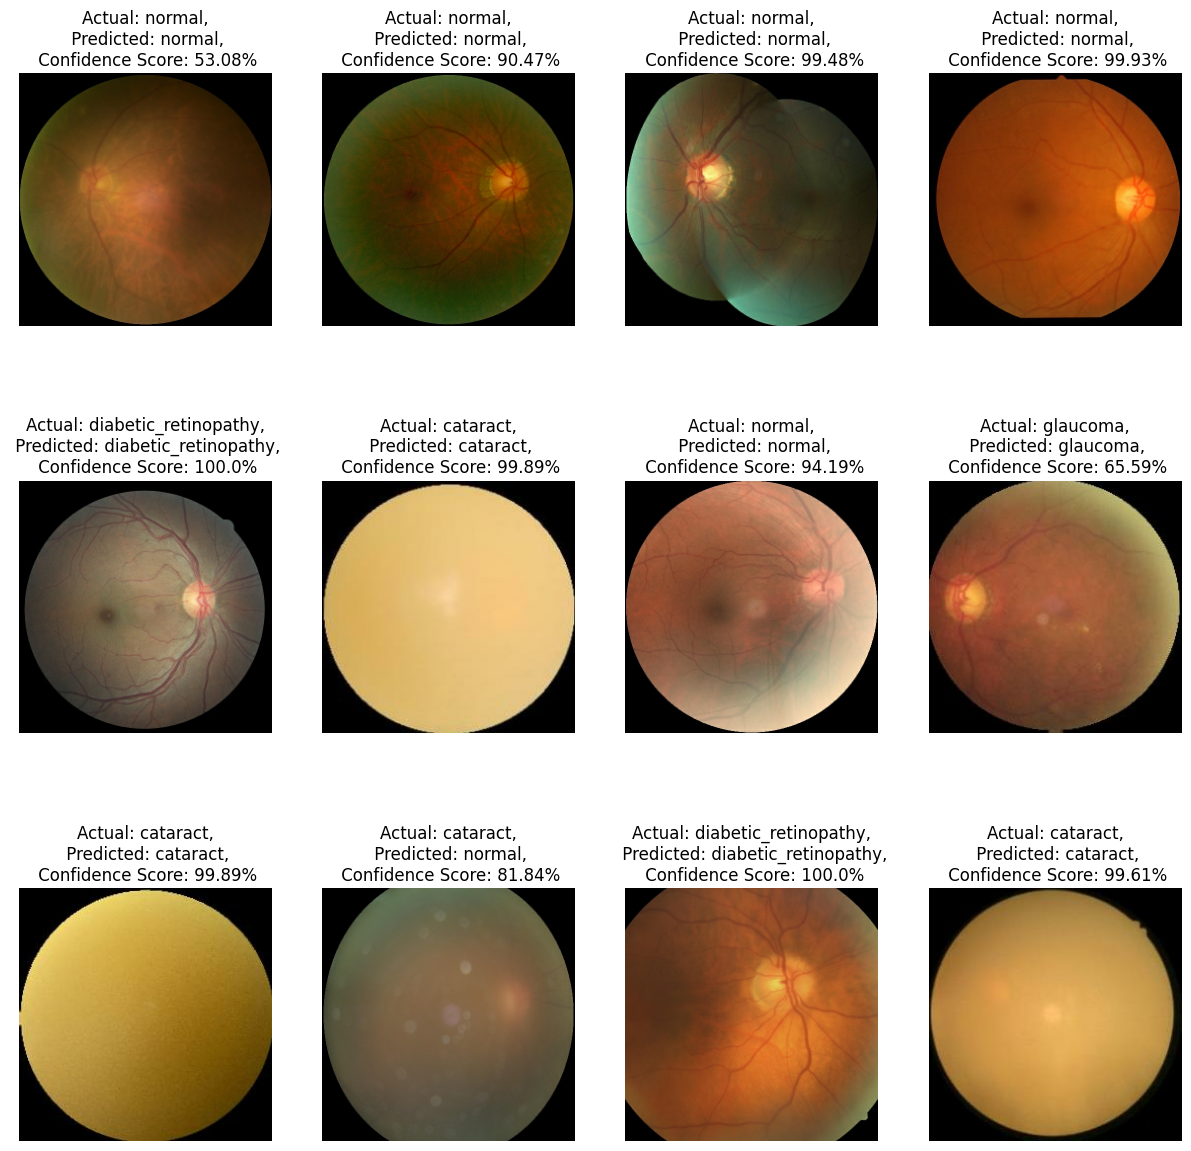

In [13]:
for images_batch, labels_batch in test_ds.take(1): 
    first_image = images_batch[0].numpy().astype('uint8')
    first_label = labels_batch[0].numpy()
    print ("First Image to Predict :")
    plt.imshow(first_image)
    print("\nActual label:",class_names[first_label])
    batch_prediction = model.predict(images_batch) 
    print("\nPredicted label" ,class_names[np.argmax(batch_prediction[0])])

def predict(model,img):
    img_array = tf.keras.preprocessing.image.img_to_array(images[i].numpy())
    img_array = tf.expand_dims(img_array, 0) # Create a batch
    predictions = model.predict (img_array)
    predicted_class = class_names[np.argmax(predictions[0])]
#     confidence = round(np.max(predictions[0]),2)
    confidence = round(100*(np.max(predictions[0])),2)

    return predicted_class, confidence

plt.figure(figsize=(15,15))
for images,labels in test_ds.take(1):
    for i in range(12):
        ax = plt.subplot(3,4,i+1)
        plt.imshow(images[i].numpy().astype("uint8"))
        
        predicted_class , confidence = predict(model,images[i].numpy())
        actual_class = class_names[labels[i]]
        
        plt.title(f"Actual: {actual_class},\n Predicted: {predicted_class},\n Confidence Score: {confidence}%")
        plt.axis("off")


In [14]:
model.save('Prediksi_Penyakit_Mata_CNN.keras')